# Домашнее задание
##Дедлайн 11.12.2024 23:59
##Загрузите работу в форму по ссылке закрепленной в конференции группы майнора
# Задание на выбор:

1.   Реализуйте свой GAN или VAE(архитектура может быть похожа на архитектуру написанную на семинаре) на датасете, невходящем в переченеь torchvision.<ol>
<li>Найдите набор данных состоящий минимум из 10 классов, укажите откуда был взят датасет (ссылку на набор данных или статью из описывающую).</li>
<li>Реализуйте GAN или VAE с обучением и инференсом.</li>
<li>Выведите все классы вашего набора данных и все сгенерированные вашей сетью классы.</li>
<li>Напишите вывод о ваших эксперементах с набором данных, архитектурой и ее параметрами.</li>
Макс оценка 10 баллов
</ol>
2.   Реализуйте готовое решение GAN или VAE взятое из открытых источников (предоставьте ссылку на источник).<ol>
<li>Если данное решение уже имеет предобученные веса и инференс на каком-то наборе данных, то загрузите свои примеры и проведите инференс.</li>
<li>Прокомментируйте все разделы кода подробно, приведите картинки(если потребуются и возможно) архитектуры или процессов, которые происходят в коде.</li>
<li>Напишите вывод о ваших эксперементах с набором данных, архитектурой и ее параметрами, приведите плюсы и минусы архитектуры.</li>
Макс оценка 7 баллов
</ol>
3.  Дообучите готовое решение GAN или VAE взятое из откртых источников (предоставьте ссылку на источник). <ol>
<li>Найдите новый набор данных другой тематики и дообучите модель, перепешите разделы кода (если понадобится) и проккоментируйте для чего это было сделано.</li>
<li>Прокомментируйте все разделы кода подробно, приведите картинки(если потребуются и возможно) архитектуры или процессов, которые происходят в коде.</li>
<li>Напишите вывод о ваших эксперементах с набором данных, архитектурой и ее параметрами, приведите плюсы и минусы архитектуры.</li>
Макс оценка 8-9 баллов в зависимости от сложности архитектуры </ol>

# Оценка может быть снижена за:
<ol>
<li>Неопрятный и непонятный код</li>
<li>Отсутствие или малое количество комментариев, описывающих код</li>
<li>За не вывод входных и выходных данных</li>
</ol>


In [2]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch import nn
import math
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/dataset.zip' dataset.zip
!unzip dataset.zip -d data/

Archive:  dataset.zip
   creating: data/dataset/
   creating: data/dataset/abigail_williams_(fate)/
  inflating: data/dataset/abigail_williams_(fate)/2953141.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2955129.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2956129.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2956134.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2956138.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2956140.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2956140149.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2956146.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2956149.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2965060.jpg  
  inflating: data/dataset/abigail_williams_(fate)/2970120.jpg  
  inflating: data/dataset/abigail_williams_(fate)/3507035.jpg  
  inflating: data/dataset/abigail_williams_(fate)/3534035.jpg  
  inflating: data/dataset/abigail_williams_(fate)/3543035.jpg  
 

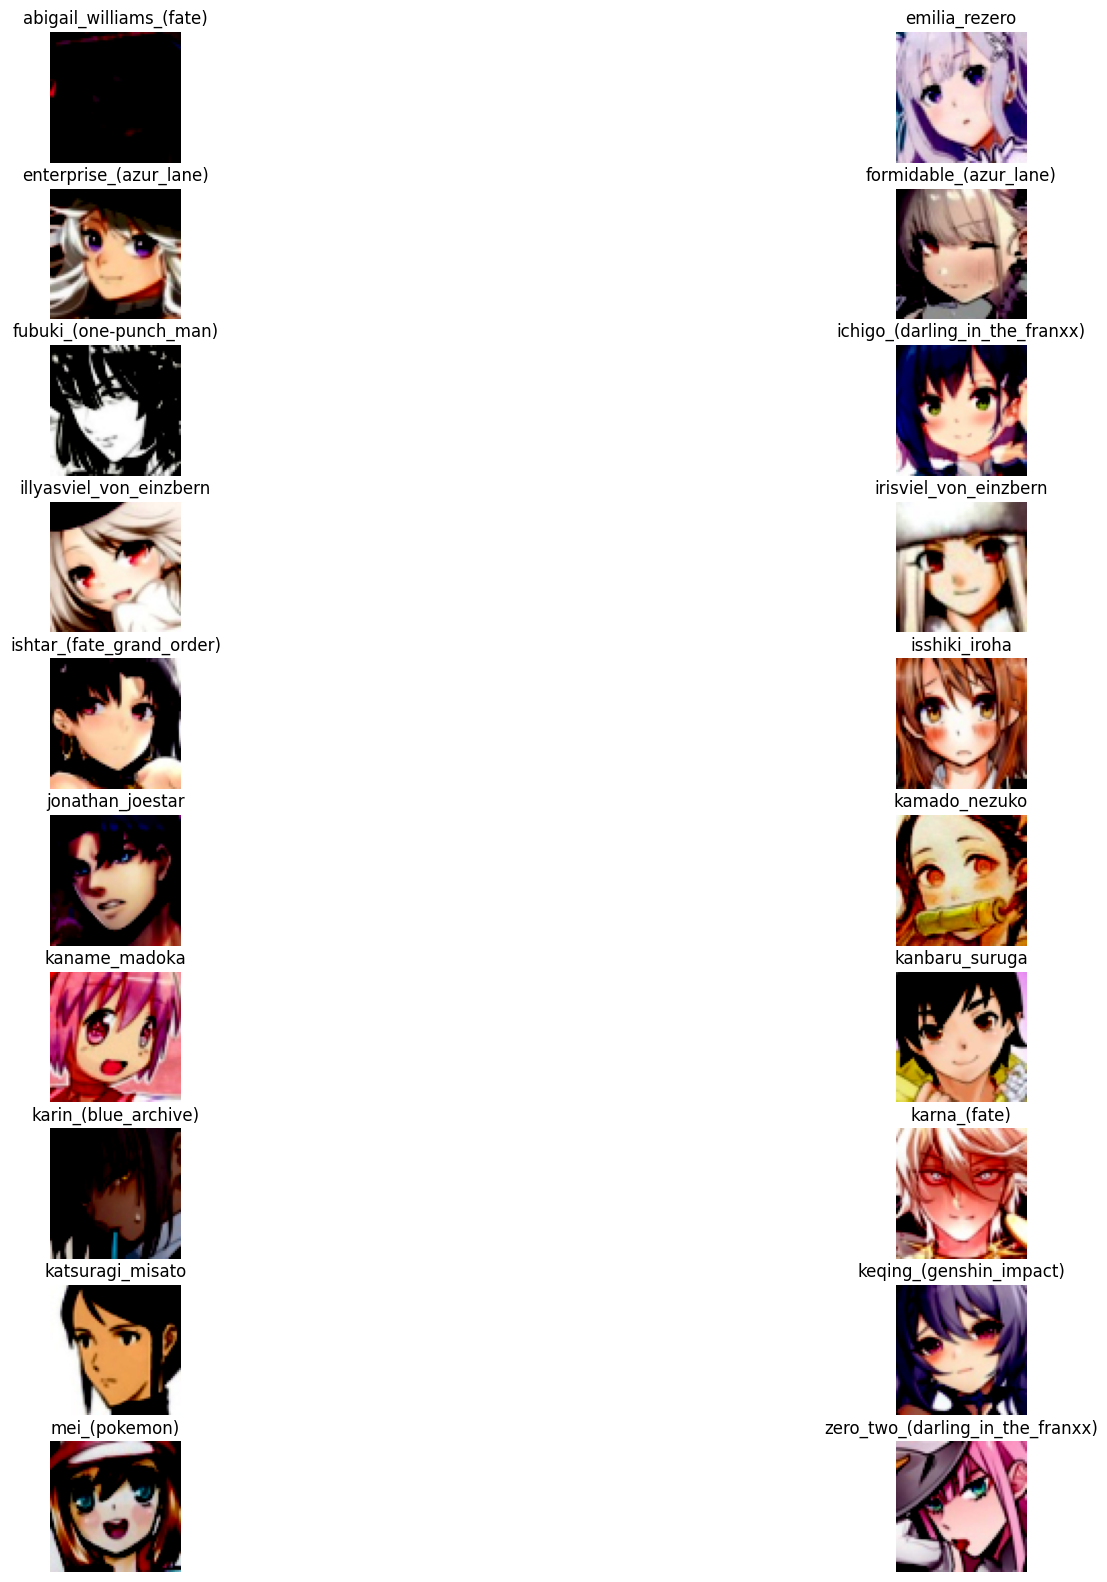

In [10]:
import zipfile
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# 2. Трансформации

# Предобработка изображений
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Изменение размера
    transforms.ToTensor(),       # Преобразование в тензор
    transforms.Normalize([0.5], [0.5])  # Нормализация в диапазон [-1, 1]
])

dataset = ImageFolder("/content/data/dataset", transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Нормализация

# 3. Использование ImageFolder
dataset = ImageFolder(root='/content/data/dataset', transform=transform)

# 4. DataLoader для итерации
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 5. Визуализация нескольких примеров
real_sample, labels = next(iter(train_loader))

class_indices = {}
for idx, (_, label) in enumerate(dataset):
    if label not in class_indices:
        class_indices[label] = idx  # Сохраняем индекс первого изображения каждого класса

# 5. Визуализация
plt.figure(figsize=(20, 20))
for i, (class_label, idx) in enumerate(class_indices.items()):
    image, label = dataset[idx]  # Извлекаем изображение и метку
    ax = plt.subplot(10, 2, i + 1)  # Задаем сетку (подстроить под количество классов)
    plt.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray_r')  # Отображаем изображение
    ax.set_title(dataset.classes[label])  # Название класса
    ax.axis('off')

In [17]:
import torch
import torch.nn as nn

# Генератор
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, img_size):
        super().__init__()
        self.img_size = img_size
        self.img_channels = img_channels
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0),  # 100 -> 128x7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 128x7x7 -> 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),     # 64x14x14 -> 3x28x28
            nn.Tanh()  # Применяется для выхода, чтобы значения были в интервале [-1, 1]
        )

    def forward(self, z):
        # Преобразуем латентный вектор в нужный формат для передачи в ConvTranspose2d
        z = z.view(z.size(0), self.latent_dim, 1, 1)  # Преобразование в формат (batch_size, latent_dim, 1, 1)
        return self.model(z)


# Дискриминатор (можно переделать по аналогии, но нужно добавить ваш код для дискриминатора)

class Discriminator(nn.Module):
    def __init__(self, img_channels, img_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),  # 3x64x64 -> 64x32x32
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x32x32 -> 128x16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 128x16x16 -> 256x8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 256x8x8 -> 512x4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),  # 512x4x4 -> 1x2x2
            nn.Sigmoid()  # Для вывода вероятности
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

latent_dim = 100
img_channels = 3  # для RGB изображений
img_size = 64
lr = 0.0002
num_epochs = 200
gen = Generator(latent_dim, img_channels, img_size).to(device)
disc = Discriminator(img_channels, img_size).to(device)

# Функция потерь и оптимизаторы
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))






In [18]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Инициализация устройства
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Параметры
latent_dim = 100
img_channels = 3  # для RGB изображений
img_size = 64
lr = 0.0002
num_epochs = 200
batch_size = 64

# Загрузка датасета
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Изменение размера
    transforms.ToTensor(),        # Преобразование в тензор
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Нормализация в диапазон [-1, 1]
])

dataset = ImageFolder("/content/data/dataset", transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Инициализация моделей
gen = Generator(latent_dim, img_channels, img_size).to(device)
disc = Discriminator(img_channels, img_size).to(device)

# Функция потерь и оптимизаторы
criterion = nn.BCELoss()
optimizer_G = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

# Функция для визуализации сгенерированных изображений
def generate_and_save_images(epoch, generator, latent_dim, examples=16, figsize=(10, 10)):
    noise = torch.randn(examples, latent_dim, 1, 1).to(device)
    with torch.no_grad():
        generated_images = generator(noise)

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i].cpu().permute(1, 2, 0).clamp(0, 1))  # Отображаем изображения
        plt.axis('off')
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

# Основной цикл обучения
from torchvision.utils import save_image

for epoch in range(num_epochs):
    for real_imgs, _ in tqdm(data_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # === Обучение дискриминатора ===
        # Метки для реальных и сгенерированных изображений
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Реальные изображения
        outputs_real = disc(real_imgs)
        outputs_real = outputs_real.view(-1)  # Преобразуем выход в одномерный тензор (batch_size, )
        real_labels = real_labels.view(-1)  # Преобразуем метки в одномерный тензор (batch_size, )

        loss_real = criterion(outputs_real, real_labels)

        # Сгенерированные изображения
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = gen(noise)
        outputs_fake = disc(fake_imgs.detach())
        outputs_fake = outputs_fake.view(-1)  # Преобразуем выход в одномерный тензор (batch_size, )
        fake_labels = fake_labels.view(-1)  # Преобразуем метки в одномерный тензор (batch_size, )

        loss_fake = criterion(outputs_fake, fake_labels)

        # Итоговая ошибка дискриминатора
        loss_D = loss_real + loss_fake

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # === Обучение генератора ===
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = gen(noise)
        outputs_fake = disc(fake_imgs)
        outputs_fake = outputs_fake.view(-1)  # Преобразуем выход в одномерный тензор (batch_size, )

        # Генератор хочет "обмануть" дискриминатор: метки для сгенерированных изображений как "реальные"
        loss_G = criterion(outputs_fake, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Логирование
    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')


  0%|          | 0/24 [00:00<?, ?it/s]


ValueError: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([256])) is deprecated. Please ensure they have the same size.

In [6]:
import torch
import matplotlib.pyplot as plt

# Переводим генератор в режим инференса
gen.eval()

# Задаём параметры
num_classes = 20  # Количество классов
latent_dim = 100  # Размер латентного вектора
batch_size = 1  # Мы генерируем одно изображение за раз

# Список для хранения сгенерированных изображений
generated_samples = []

# Получаем список классов из dataset (из ImageFolder)
class_names = dataset.classes

# Генерация по одному изображению для каждого класса
for class_idx in range(num_classes):
    # Генерация шума с небольшим смещением для каждого класса
    noise = torch.randn(batch_size, latent_dim).to(device)
    noise += class_idx * 0.1  # Смещение для различия между классами

    # Генерация изображения
    generated_img = gen(noise).detach().cpu()  # Генерация изображения
    generated_samples.append(generated_img)

# Визуализация сгенерированных изображений для каждого класса
plt.figure(figsize=(12, 12))
for i in range(num_classes):
    ax = plt.subplot(5, 5, i + 1)  # 5x5 сетка для 20 классов
    plt.imshow(generated_samples[i].squeeze().permute(1, 2, 0), cmap='gray')  # Сжимаем изображение и меняем оси
    plt.title(f"Class: {class_names[i]}")  # Название класса
    plt.axis('off')

plt.tight_layout()
plt.show()




NameError: name 'gen' is not defined